In [1]:
"""
Simple tester for the vgg19_trainable
"""
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf

import vgg16_new as vgg16
import os
import time
import numpy as np
from IPython.display import clear_output
import sys
import csv

PRETRAINED_MODEL_PATH= "/mnt/data1/imagenet-data/ckpt_dir"
N_EPOCHS = 300
INIT_LEARNING_RATE = 0.01
WEIGHT_DECAY_RATE = 0.0005
MOMENTUM = 0.9
IMAGE_HEIGHT  = 224    #960
IMAGE_WIDTH   = 224    #720
NUM_CHANNELS  = 3
BATCH_SIZE = 90
N_CLASSES = 1000
DROPOUT = 0.50
ckpt_dir = "/mnt/data1/imagenet-data/ckpt_dir"
#LOGS_PATH = '/home/sik4hi/tensorflow_logs'
WEIGHT_PATH = '.npy'
TRAINSET_PATH = '/mnt/data1/imagenet-data/csv-files/train2/imagenetdataall0.csv'
VALSET_PATH ='/mnt/data1/imagenet-data/csv-files/val/imagenetdata0.csv'

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#=======================================================================================================
# Reading Training data from CSV FILE
#=======================================================================================================
train_csv_path=open(TRAINSET_PATH,"r")
train_filepaths=[]
train_labels=[]
for line in train_csv_path:
    filepath, label= line.split(",")
    label= int(label)
    train_filepaths.append(filepath)
    train_labels.append(label)
    
val_csv_file=open(VALSET_PATH,"r")
val_filepaths=[]
val_labels=[]
for line in val_csv_file:
    filepath, label= line.split(",")
    label= int(label)
    val_filepaths.append(filepath)
    val_labels.append(label)
    
with tf.device('/cpu:0'):
    def _compute_longer_edge(height, width, new_shorter_edge):
        return tf.cast(width*new_shorter_edge/height, tf.int32)

    
    train_image_path , train_label = tf.train.slice_input_producer([train_filepaths,train_labels]
                                           ,capacity = 100000, shuffle=True)
    
    
    train_image_content = tf.read_file(train_image_path)
    train_image = tf.image.decode_jpeg(train_image_content, channels=3)
    
    shape = tf.shape(train_image)
    height = shape[0]
    width = shape[1]
    new_shorter_edge = tf.constant(256, dtype=tf.int32)

    height_smaller_than_width = tf.less_equal(height, width)
    new_height_and_width = tf.cond(
        height_smaller_than_width,
        lambda: (new_shorter_edge, _compute_longer_edge(height, width, new_shorter_edge)),
        lambda: (_compute_longer_edge(width, height, new_shorter_edge), new_shorter_edge)
    )
    size = tf.cast([new_height_and_width[0], new_height_and_width[1]], tf.int32)
    train_image = tf.image.resize_images(train_image, size)
    size = tf.cast([IMAGE_HEIGHT, IMAGE_WIDTH, 3], tf.int32)
    train_image = tf.random_crop(train_image, size)
    train_image = tf.image.random_flip_left_right(train_image)
    train_image = tf.cast(train_image, tf.float32)/255. # necessary for mapping rgb channels from 0-255 to 0-1 float.
    train_label = tf.cast(train_label, tf.int64) # unnecessary
    train_image_batch, train_label_batch = tf.train.batch([train_image, train_label], batch_size=BATCH_SIZE,
                                                                  capacity = 1000 + 3*BATCH_SIZE, 
                                                                  num_threads=7)
    
    
    val_image_path , val_label = tf.train.slice_input_producer([val_filepaths,val_labels]
                                           ,capacity = 100000, shuffle=True)
    
    
    val_image_content = tf.read_file(val_image_path)
    val_image = tf.image.decode_jpeg(val_image_content, channels=3)
    
    shape = tf.shape(val_image)
    height = shape[0]
    width = shape[1]
    new_shorter_edge = tf.constant(256, dtype=tf.int32)

    height_smaller_than_width = tf.less_equal(height, width)
    new_height_and_width = tf.cond(
        height_smaller_than_width,
        lambda: (new_shorter_edge, _compute_longer_edge(height, width, new_shorter_edge)),
        lambda: (_compute_longer_edge(width, height, new_shorter_edge), new_shorter_edge)
    )
    size = tf.cast([new_height_and_width[0], new_height_and_width[1]], tf.int32)
    val_image = tf.image.resize_images(val_image, size)
    
    size = tf.cast([IMAGE_HEIGHT, IMAGE_WIDTH, 3], tf.int32)
    val_image = tf.random_crop(val_image, size)
    
    val_image = tf.image.random_flip_left_right(val_image)
    val_image = tf.cast(val_image, tf.float32)/255. # necessary for mapping rgb channels from 0-255 to 0-1 float.
    val_label = tf.cast(val_label, tf.int64) # unnecessary
    val_image_batch, val_label_batch = tf.train.batch([val_image, val_label], batch_size=BATCH_SIZE,
                                                                  capacity = 1000 + 3*BATCH_SIZE, 
                                                                  num_threads=7)
    
with tf.device('/gpu:0'):
   
    
    
    #images_tf = tf.placeholder(tf.float32, [None, 224, 224, 3])
    #labels_tf = tf.placeholder(tf.int64)
    train_mode = tf.placeholder(tf.bool)

    vgg = vgg16.Vgg16()
    
    if train_mode is not None:
        images_tf=tf.cond(train_mode, lambda:train_image_batch, lambda:val_image_batch)
    if train_mode is not None:
        labels_tf=tf.cond(train_mode, lambda:train_label_batch, lambda:val_label_batch)
                          
    
    vgg.build(images_tf, train_mode=train_mode)

    #==============================================================================================================
    # Defining Loss, could be changed from cross entropy depending on needs. The current configuration works well on
    # multiclass (not hot-encoded vectors) prediction like ImageNET.
    #==============================================================================================================
    with tf.name_scope('Loss'):
        loss_tf = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(vgg.fc8, labels_tf), name='loss_tf')
        l2_loss=tf.reduce_sum(tf.get_collection("losses"))
        
        loss_tf2 =loss_tf + l2_loss

    # ==============================================================================================================
    # Optimizer, again it can be changed to any function provided by Tensorflow. You can simply use commented out line
    # instead of explicitly computing gradients, if you are not interested in creating summaries of gradients.
    # ==============================================================================================================
    #train_op = tf.train.MomentumOptimizer(learning_rate, MOMENTUM).minimize(loss_tf2)
    train_op = tf.train.AdamOptimizer(learning_rate=0.0001,epsilon=0.1).minimize(loss_tf2)
    #optimizer = tf.train.MomentumOptimizer(learning_rate, MOMENTUM)
    #grads_and_vars = optimizer.compute_gradients(loss_tf)
    #grads_and_vars = map(
     #   lambda gv: (gv[0], gv[1]) if ('conv6' in gv[1].name or 'GAP' in gv[1].name) else (gv[0] * 0.1, gv[1]),
      #  grads_and_vars)
    #grads_and_vars = [(tf.clip_by_value(gv[0], -5., 5.), gv[1]) for gv in grads_and_vars]
    #train_op = optimizer.apply_gradients(grads_and_vars)


    # ===================================================================================================================
    # Accuracy for the current batch
    # ===================================================================================================================
    correct_pred = tf.equal(tf.argmax(vgg.fc8, 1), labels_tf)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

with tf.device('/cpu:0'):    
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
    saver = tf.train.Saver(max_to_keep=10)
    
with tf.device('/gpu:0'):
    sess = tf.Session()
    init_op = tf.group(tf.initialize_all_variables(),
                       tf.initialize_local_variables())
    sess.run(init_op)
    if PRETRAINED_MODEL_PATH:
        print "using Pretrained model"
        ckpt = tf.train.get_checkpoint_state(PRETRAINED_MODEL_PATH)
        print(ckpt)
        saver.restore(sess,ckpt.model_checkpoint_path)
        
    coord=tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    print("finished")

('conv1_1', '2d Value Initialized')
conv1_1_filters_W [3, 3, 3, 64]
('conv1_1', 'L2 Loss Added')
('conv1_1', 'Value Initialized 0')
conv1_1_biases [64]
('conv1_2', '2d Value Initialized')
conv1_2_filters_W [3, 3, 64, 64]
('conv1_2', 'L2 Loss Added')
('conv1_2', 'Value Initialized 0')
conv1_2_biases [64]
('conv2_1', '2d Value Initialized')
conv2_1_filters_W [3, 3, 64, 128]
('conv2_1', 'L2 Loss Added')
('conv2_1', 'Value Initialized 0')
conv2_1_biases [128]
('conv2_2', '2d Value Initialized')
conv2_2_filters_W [3, 3, 128, 128]
('conv2_2', 'L2 Loss Added')
('conv2_2', 'Value Initialized 0')
conv2_2_biases [128]
('conv3_1', '2d Value Initialized')
conv3_1_filters_W [3, 3, 128, 256]
('conv3_1', 'L2 Loss Added')
('conv3_1', 'Value Initialized 0')
conv3_1_biases [256]
('conv3_2', '2d Value Initialized')
conv3_2_filters_W [3, 3, 256, 256]
('conv3_2', 'L2 Loss Added')
('conv3_2', 'Value Initialized 0')
conv3_2_biases [256]
('conv3_3', '2d Value Initialized')
conv3_3_filters_W [3, 3, 256, 256]
(

In [2]:
epoch=71

===========**Training ACCURACY**================
Epoch: 81
Training Accuracy:  0.804837
Training Loss: 0.71506
L2 Loss: 0.833914
===========**VALIDATION ACCURACY**================
Epoch: 81
Validation Accuracy:  0.694134
Validation Loss: 1.30187
Time Elapsed for Epoch:81 is 284.253789981 minutes


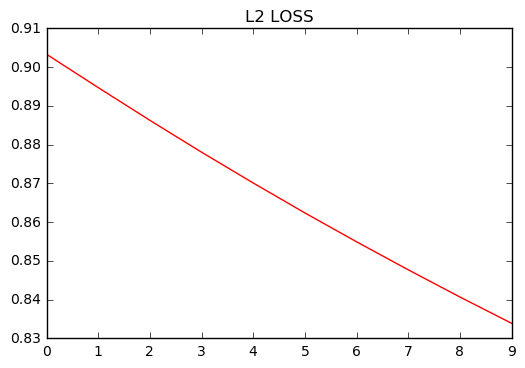

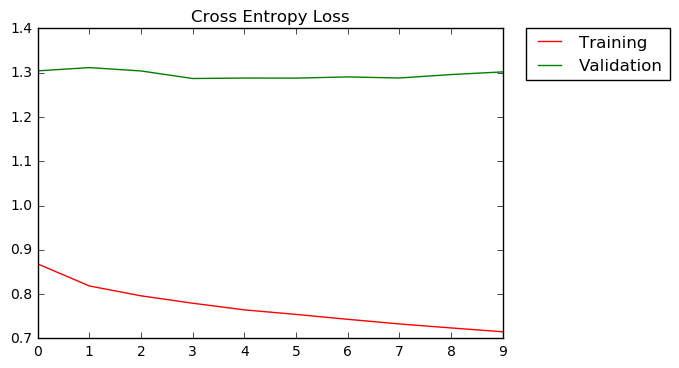

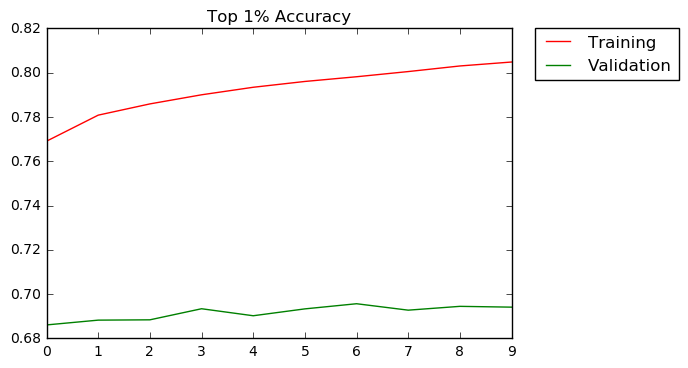

('file saved', '/mnt/data1/imagenet-data/weights/vgg-epoch-81.npy')
14234
Iteration:2847  Loss: 0.870796 L2 Loss: 0.829277requesting stop


KeyboardInterrupt: 

In [3]:
train_loss_list, train_accuracy_list, plot_train_loss, plot_train_accuracy,l2_loss_list, plot_l2_loss =  [], [], [], [], [], []
val_loss_list , val_accuracy_list ,plot_val_loss, plot_val_accuracy = [], [], [], []

try:   
    while not coord.should_stop() and epoch< N_EPOCHS:
        epoch+=1
        epoch_start_time = time.time()
        print((1281144 / BATCH_SIZE))
        for i in xrange((1281144/ BATCH_SIZE)):
            _, train_loss,l2_train_loss, train_accuracy = sess.run(
               [train_op, loss_tf, l2_loss, accuracy],feed_dict={train_mode: True})

            train_loss_list.append(train_loss)
            train_accuracy_list.append(train_accuracy)
            l2_loss_list.append(l2_train_loss)
            sys.stdout.write('\r\r' + "Iteration:" + str(i)+ "  Loss: "+ str(train_loss)+ " L2 Loss: "+ str(l2_train_loss))
            sys.stdout.flush()
        
        
        train_loss_mean = np.mean(train_loss_list)
        train_accuracy_mean = np.mean(train_accuracy_list)
        l2_loss_mean = np.mean(l2_loss_list)
        
        plot_train_loss.append(train_loss_mean)
        plot_train_accuracy.append(train_accuracy_mean)
        plot_l2_loss.append(l2_loss_mean)
      
        train_loss_list = []
        train_accuracy_list = []
        l2_loss_list=[]
        
        print((50000 / BATCH_SIZE))
        for i in xrange((50000/ BATCH_SIZE)):
            val_loss, val_accuracy = sess.run(
               [loss_tf, accuracy],feed_dict={train_mode: False})

            val_loss_list.append(val_loss)
            val_accuracy_list.append(val_accuracy)
            sys.stdout.write('\r\r' + "Iteration:" + str(i)+ "  Loss: "+ str(val_loss))
            sys.stdout.flush()
        
        
        val_loss_mean = np.mean(val_loss_list)
        val_accuracy_mean = np.mean(val_accuracy_list)
        
        plot_val_loss.append(val_loss_mean)
        plot_val_accuracy.append(val_accuracy_mean)
      
        val_loss_list = []
        val_accuracy_list = []
                
            

        clear_output()
        print "===========**Training ACCURACY**================"
        print "Epoch:", epoch
        print 'Training Accuracy: ', train_accuracy_mean       
        print "Training Loss:", train_loss_mean 
        print "L2 Loss:", l2_loss_mean
        
        print "===========**VALIDATION ACCURACY**================"
        print 'Epoch:', epoch
        print 'Validation Accuracy: ', val_accuracy_mean
        print "Validation Loss:", val_loss_mean
        
        print 'Time Elapsed for Epoch:' + str(epoch) + ' is ' + str(
            (time.time() - epoch_start_time) / 60.) + ' minutes'

        plt.figure(1) 
        aa = plt.plot(plot_l2_loss,'r')
        plt.title("L2 LOSS")
        plt.figure(2) 
        aa = plt.plot(plot_train_loss,'r',label="Training")
        bb = plt.plot(plot_val_loss,'g',label="Validation")
        plt.title("Cross Entropy Loss")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.figure(3)
        cc = plt.plot(plot_train_accuracy,'r',label="Training")
        dd = plt.plot(plot_val_accuracy,'g',label="Validation")
        plt.title("Top 1% Accuracy")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()

        
        saver.save(sess, ckpt_dir + "/model.ckpt", global_step=epoch)
        vgg.save_npy(sess, '/mnt/data1/imagenet-data/weights/vgg-epoch-' + str(epoch) + '.npy')
        ofile  = open('datawval.csv', "a")
        writer = csv.writer(ofile)
        timep=((time.time() - epoch_start_time) / 60.)
        writer.writerow([train_loss_mean,train_accuracy_mean,l2_loss_mean,timep,val_loss_mean,val_accuracy_mean,epoch])
        ofile.close()
except tf.errors.OutOfRangeError:
    print ("out of range")
finally:
    coord.request_stop()
    coord.join(threads)
    print("requesting stop")